<a href="https://colab.research.google.com/github/Dichik/ai-house-fake-news-detection-course/blob/main/week-3/week-3-session-2-clustering-and-topic-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyLDAvis
!pip install sentence_transformers
!pip install langdetect
!pip install datasets
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 285, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 75, in get_default_session
    self._session = self.enter_context(self._build_session(options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 89, in _build_session
    session = PipSession(
  File "/usr/loc

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim_models

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from langdetect import detect as detect_lang
from datasets import Dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic
from sklearn.metrics import silhouette_score, calinski_harabasz_score

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
tqdm.pandas()

### Load dataset from Kaggle (private repo)

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vladimirsydor/ru-propaganda-2022-year

In [ ]:
!unzip ru-propaganda-2022-year

In [ ]:
!rm ./ru-propaganda-2022-year.zip

# Homework 6

- Try to build some statistics with `Date` and `Time` features. Number of posts in different months, day of weeks, time of day and etc.
- Try to apply clustering; dimensionality reduction + clustering; topic modelling for finding interesting topics 
- Try to check popularity (number of posts) for the most popular topics from previous step depending on `Date`

Advanced Practice:
- Try to implement some `Class`, which can 
    - Automatically find topics
    - Create descriptions for them: Keywords or/and Keyword N-Grams or/and other rules
    - Detect them and track them by Time

#### Steps to get `text_table_processed.csv` file

1. `df = pd.read_csv("./text_table.csv")`
2. `df = df[~df[["Text", "Saved at", "Date", "Time"]].isna().any(axis=1)].reset_index(drop=True)`
3. `df["Text_processed"] = df["Text"].apply(process_text)`

where `process_text` is:

```python
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

df["Text_processed"] = df["Text"].apply(process_text)
```

#### Tasks

In [2]:
df = pd.read_csv("./text_table_processed.csv", converters={"Date": pd.to_datetime})
df["lang"].value_counts()

ru       1036181
en        364208
uk         84710
de         23341
fr         13509
bg          7876
es          6467
no          2625
none        1799
et          1785
hi          1767
af          1670
id          1541
vi          1095
fi           959
da           714
ca           597
ro           584
fa           535
mk           524
ta           519
ml           459
it           446
lt           431
bn           391
pt           349
so           318
nl           281
sv           247
ar           203
sw           191
gu           181
hr           167
tr           154
tl           143
sl           143
sq           120
kn           117
pl           103
ja            93
cs            67
te            59
sk            55
ne            51
pa            42
el            35
hu            22
th            18
ko            14
cy            13
lv            11
zh-cn          5
he             4
Name: lang, dtype: int64

In [3]:
df.head()

,Title,Text,Saved at,Date,Time,lang,Text_processed
0,NaN,[18/20] 📚@Geo_Hub93 📚\n\n📚In which of the foll...,2022-03-13 12:21:06.349070200+00:00,2022-03-13,12:12:28,en,[18/20] @Geo_Hub93 . In which of the following...
1,Опять оккупанты что-то попутали. Рассказывать ...,"Вот, россияне, посмотрите на действительно сво...",2022-03-13 12:21:10.126565500+00:00,2022-03-13,09:38:01,ru,"Вот, россияне, посмотрите на действительно сво..."
2,NaN,Русский солдат – фашистский оккупант!\n\nВот к...,2022-03-13 12:21:10.529583400+00:00,2022-03-13,12:20:08,ru,Русский солдат фашистский оккупант! Вот как Хе...
3,NaN,"«Страшно не то, что нас убивают, а то, что кид...",2022-03-13 12:21:12.061685200+00:00,2022-03-13,09:58:15,uk,"Страшно не то, что нас убивают, а то, что кида..."
4,NaN,Обязательно посмотрите это видео!\n\nПутин хоч...,2022-03-13 12:21:12.613800100+00:00,2022-03-13,10:03:27,ru,Обязательно посмотрите это видео! Путин хочет ...


In [4]:
df['Text_processed'].head()

0    [18/20] @Geo_Hub93 . In which of the following...
1    Вот, россияне, посмотрите на действительно сво...
2    Русский солдат фашистский оккупант! Вот как Хе...
3    Страшно не то, что нас убивают, а то, что кида...
4    Обязательно посмотрите это видео! Путин хочет ...
Name: Text_processed, dtype: object

In [5]:
df = df[df["lang"] == "ru"].reset_index(drop=True)

In [6]:
df.shape

(1036181, 7)

## Extract News embeddings

#### How we got `news_embeddings.npy` file

```python
sent_emb_model = SentenceTransformer("DeepPavlov/rubert-base-cased", device="cuda")
news_embeddings = sent_emb_model.encode(df["Text_processed"].to_list(), show_progress_bar=True, batch_size=100
np.save(
    "../data/ru_propaganda_2022_year/news_embeddings.npy",
    news_embeddings
)
```

In [7]:
news_embeddings = np.load("./news_embeddings.npy")
assert news_embeddings.shape[0] == df.shape[0]

In [8]:
# Drop NaN rows, in order to keep df and news_embeddings alligned

df = df[~df["Text_processed"].isna()]
news_embeddings = news_embeddings[df.index.values]
df = df.reset_index(drop=True)

<a id='Text_Embeddings_clustering'></a>
# Text Embeddings clustering

## Pipeline 

1. Take some Texts subset (just as an example)
2. Aplly TSNE and visualise 
3. According to visualisation - pick number of Clusters for KMeans. 
4. Examine KMeans clusters 
5. Try to estimate optimal distance treshold for DBSCAN from KMeans clustres 
6. Examine DBSCAN clusters 

(+) TODO: Try to repeat this Pipeline, inplacing TSNE with PCA on the first step 

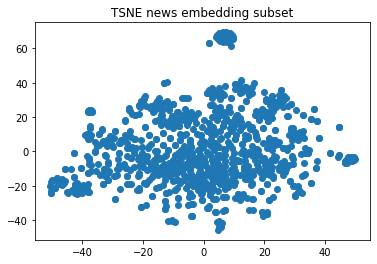

In [9]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(news_embeddings[:1000])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

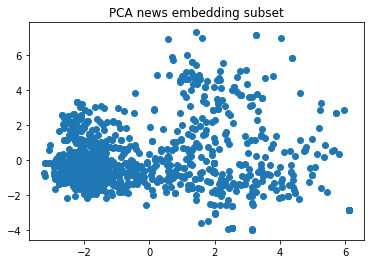

In [10]:
pca_news_embeddings_subset = PCA(random_state=42).fit_transform(news_embeddings[:1000])

plt.title("PCA news embedding subset")
plt.scatter(pca_news_embeddings_subset[:,0], pca_news_embeddings_subset[:,1])
plt.show()

From these two visulizations we can see that values in PCA are less distributed.

(+) TODO: Try to pick n_clusters using [clustering metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) 

silhouette_score: 0.35024493932724 for n_clusters=2
calinski_harabasz_score: 634.9080958493823 for n_clusters=2


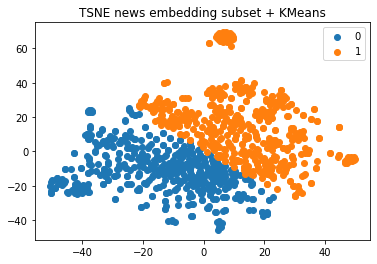

silhouette_score: 0.3845009207725525 for n_clusters=3
calinski_harabasz_score: 795.7362896356135 for n_clusters=3


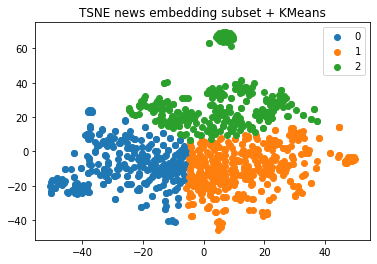

silhouette_score: 0.3609866201877594 for n_clusters=4
calinski_harabasz_score: 778.9218932167773 for n_clusters=4


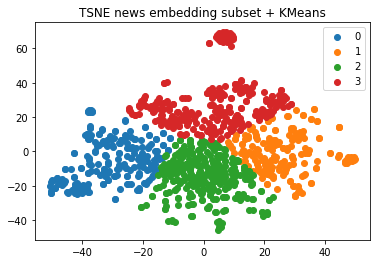

silhouette_score: 0.3672139644622803 for n_clusters=5
calinski_harabasz_score: 805.1337650182816 for n_clusters=5


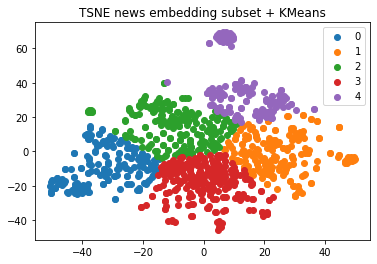

silhouette_score: 0.38570886850357056 for n_clusters=6
calinski_harabasz_score: 843.4872168481339 for n_clusters=6


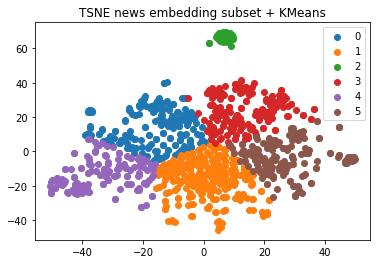

silhouette_score: 0.3920208215713501 for n_clusters=7
calinski_harabasz_score: 881.595867714335 for n_clusters=7


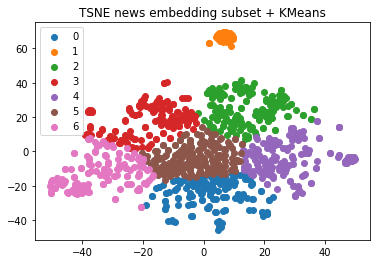

silhouette_score: 0.3890618085861206 for n_clusters=8
calinski_harabasz_score: 895.3101542948555 for n_clusters=8


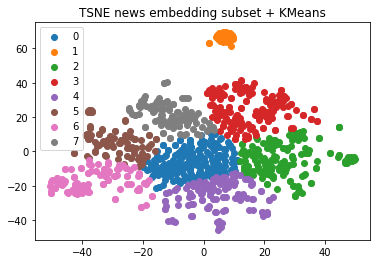

silhouette_score: 0.3929654657840729 for n_clusters=9
calinski_harabasz_score: 920.3496621962358 for n_clusters=9


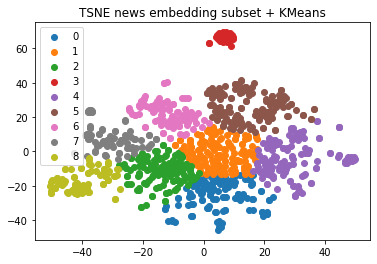

silhouette_score: 0.38903191685676575 for n_clusters=10
calinski_harabasz_score: 953.3136894695808 for n_clusters=10


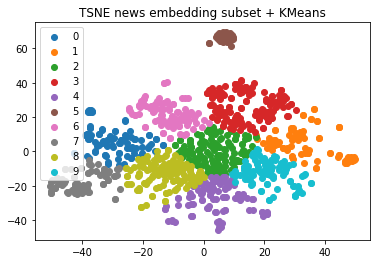

silhouette_score: 0.3852459788322449 for n_clusters=11
calinski_harabasz_score: 952.2634742037079 for n_clusters=11


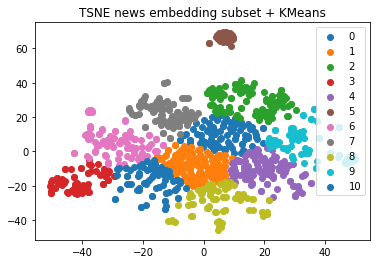

best silhouette_score: 0.3929654657840729 for n_clusters=9
best calinski_harabasz_score: 953.3136894695808 for n_clusters=10


In [11]:
best_n_clusters_SS = 0
best_n_clusters_CHS = 0
best_score_SS = 0
best_score_CHS = 0

for n_clusters in range(2, 12):
  kmeans_clusts_news_embeddings_subset = KMeans(
      n_clusters=n_clusters, 
      random_state=42, 
      init="k-means++"
  ).fit_predict(tsne_news_embeddings_subset)
  
  _silhouette_score = silhouette_score(tsne_news_embeddings_subset, kmeans_clusts_news_embeddings_subset)
  _calinski_harabasz_score = calinski_harabasz_score(tsne_news_embeddings_subset, kmeans_clusts_news_embeddings_subset)
  
  best_n_clusters_SS = n_clusters if best_score_SS < _silhouette_score else best_n_clusters_SS
  best_score_SS = max(best_score_SS, _silhouette_score)

  best_n_clusters_CHS = n_clusters if best_score_CHS < _calinski_harabasz_score else best_n_clusters_CHS
  best_score_CHS = max(best_score_CHS, _calinski_harabasz_score)

  print(f"silhouette_score: {_silhouette_score} for n_clusters={n_clusters}")
  print(f"calinski_harabasz_score: {_calinski_harabasz_score} for n_clusters={n_clusters}")

  plt.title("TSNE news embedding subset + KMeans")
  for clust in np.unique(kmeans_clusts_news_embeddings_subset):
      plt.scatter(
          tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
          tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
          label=str(clust)
      )
  plt.legend()
  plt.show()

print(f"best silhouette_score: {best_score_SS} for n_clusters={best_n_clusters_SS}")
print(f"best calinski_harabasz_score: {best_score_CHS} for n_clusters={best_n_clusters_CHS}")

Here we can see that using silhouette_score we have best result for 9 clusters. But using calinski_harabasz_score we have 10 clusters. So let's choose 10 clusters for our problem.
```
best silhouette_score: 0.3929654657840729 for n_clusters=9
best calinski_harabasz_score: 953.3136894695808 for n_clusters=10
```

silhouette_score: 0.13859887421131134 for n_clusters=2
calinski_harabasz_score: 98.39716594275204 for n_clusters=2


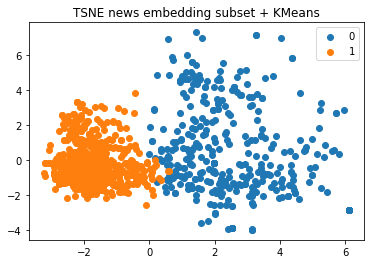

silhouette_score: 0.14725501835346222 for n_clusters=3
calinski_harabasz_score: 74.23047070358952 for n_clusters=3


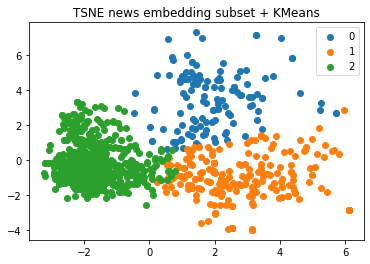

silhouette_score: 0.16192753612995148 for n_clusters=4
calinski_harabasz_score: 64.08611778951011 for n_clusters=4


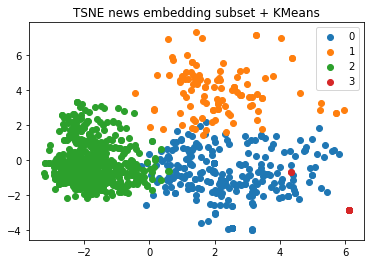

silhouette_score: 0.1563151478767395 for n_clusters=5
calinski_harabasz_score: 56.90877854443462 for n_clusters=5


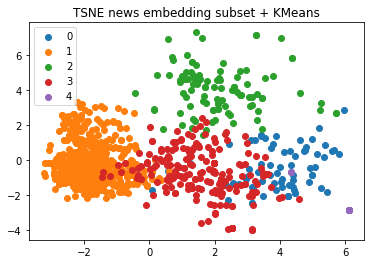

silhouette_score: 0.14359325170516968 for n_clusters=6
calinski_harabasz_score: 50.227764951219754 for n_clusters=6


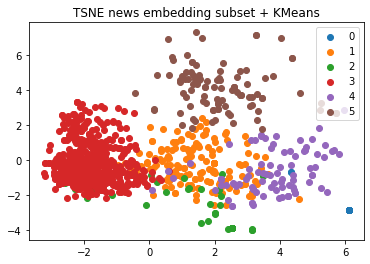

silhouette_score: 0.05025416985154152 for n_clusters=7
calinski_harabasz_score: 45.49074844139991 for n_clusters=7


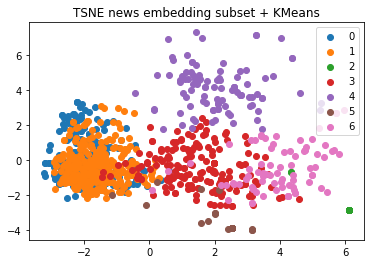

silhouette_score: 0.15859554708003998 for n_clusters=8
calinski_harabasz_score: 42.79077050959839 for n_clusters=8


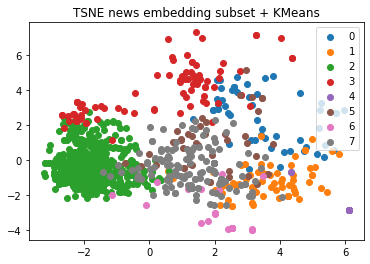

silhouette_score: 0.05568533390760422 for n_clusters=9
calinski_harabasz_score: 39.57890833802613 for n_clusters=9


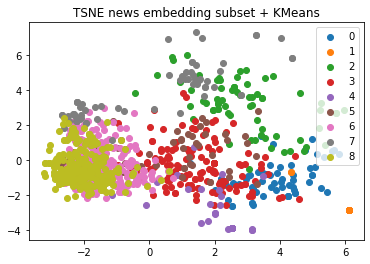

silhouette_score: 0.059047162532806396 for n_clusters=10
calinski_harabasz_score: 37.25831131932296 for n_clusters=10


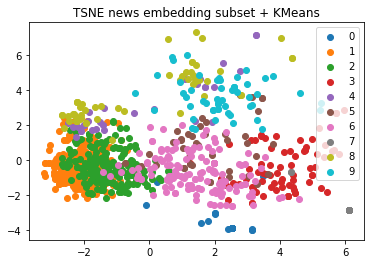

silhouette_score: 0.06724737584590912 for n_clusters=11
calinski_harabasz_score: 35.981813603521736 for n_clusters=11


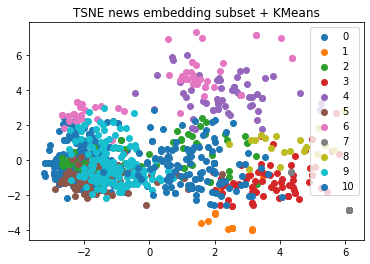

best silhouette_score: 0.16192753612995148 for n_clusters=4
best calinski_harabasz_score: 98.39716594275204 for n_clusters=2


In [12]:
# Let's check with PCA

best_n_clusters_SS = 0
best_n_clusters_CHS = 0
best_score_SS = 0
best_score_CHS = 0

for n_clusters in range(2, 12):
  kmeans_clusts_news_embeddings_subset = KMeans(
      n_clusters=n_clusters, 
      random_state=42, 
      init="k-means++"
  ).fit_predict(pca_news_embeddings_subset)

  from sklearn.metrics import silhouette_score, calinski_harabasz_score
  
  _silhouette_score = silhouette_score(pca_news_embeddings_subset, kmeans_clusts_news_embeddings_subset)
  _calinski_harabasz_score = calinski_harabasz_score(pca_news_embeddings_subset, kmeans_clusts_news_embeddings_subset)
  
  best_n_clusters_SS = n_clusters if best_score_SS < _silhouette_score else best_n_clusters_SS
  best_score_SS = max(best_score_SS, _silhouette_score)

  best_n_clusters_CHS = n_clusters if best_score_CHS < _calinski_harabasz_score else best_n_clusters_CHS
  best_score_CHS = max(best_score_CHS, _calinski_harabasz_score)

  print(f"silhouette_score: {_silhouette_score} for n_clusters={n_clusters}")
  print(f"calinski_harabasz_score: {_calinski_harabasz_score} for n_clusters={n_clusters}")

  plt.title("TSNE news embedding subset + KMeans")
  for clust in np.unique(kmeans_clusts_news_embeddings_subset):
      plt.scatter(
          pca_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
          pca_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
          label=str(clust)
      )
  plt.legend()
  plt.show()

print(f"best silhouette_score: {best_score_SS} for n_clusters={best_n_clusters_SS}")
print(f"best calinski_harabasz_score: {best_score_CHS} for n_clusters={best_n_clusters_CHS}")

So here we can see: 
```
best silhouette_score: 0.16192753612995148 for n_clusters=4
best calinski_harabasz_score: 98.39716594275204 for n_clusters=2
```
that has much worse result on both score metrics. So PCA doesn't work well here

In [13]:
kmeans_clusts_news_embeddings_subset = KMeans(
      n_clusters=n_clusters, 
      random_state=42, 
      init="k-means++"
  ).fit_predict(tsne_news_embeddings_subset)

In [14]:
df.iloc[:1000][kmeans_clusts_news_embeddings_subset == 6].Text.to_list()

['Генеральный секретарь НАТО заявил, что Россия может планировать химические атаки. По словам Столтенберга, после заявлений Москвы об американских биолабораториях на Украине НАТО «должно сохранять бдительность». Также он добавил, что подобные решения России были бы «военным преступлением».\nРанее в Минобороны заявили, что получили сведения о лабораториях США на Украине. Проект якобы касается распространения опасных инфекций мигрирующими птицами\nГенеральный секретарь НАТО заявил, что Россия может планировать химические атаки. По словам',
 'Представитель Кремля Дмитрий Песков высказался о возможности встречи президентов РФ и Украины Владимира Путина и Владимира Зеленского\r\nПесков прокомментировал возможность встречи Путина и Зеленского: «Никто не исключает»\r\nПредставитель Кремля Дмитрий Песков высказался о возможности встречи президентов РФ и Украины Владимира Путина и Владимира Зеленского\r\nhttps://www.mk.ru/politics/2022/03/13/peskov-prokommentiroval-vozmozhnost-vstrechi-putina-i

In [15]:
df_no_dupl = df.drop_duplicates("Text_processed")
news_embeddings_no_dupl = news_embeddings[df_no_dupl.index.values]
df_no_dupl = df_no_dupl.reset_index(drop=True)

In [16]:
df["Text_processed"].head()

0    Вот, россияне, посмотрите на действительно сво...
1    Русский солдат фашистский оккупант! Вот как Хе...
2    Обязательно посмотрите это видео! Путин хочет ...
3    Если я правильно все понимаю, то по версии рос...
4    Опять оккупанты что-то попутали. Рассказывать ...
Name: Text_processed, dtype: object

In [17]:
# TODO: drop duplicates by `substrings` 

# df_no_substrs = df.drop_duplicates(subset=['Text_processed'], keep='first')
# news_embeddings_no_dupl = news_embeddings[df_no_dupl.index.values]
# df_no_dupl = df_no_dupl.reset_index(drop=True)

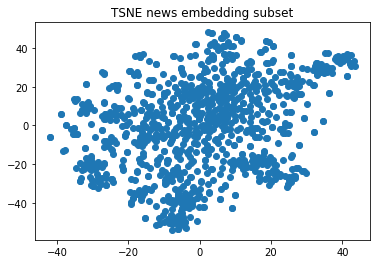

In [18]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(news_embeddings_no_dupl[:1000])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

calinski_harabasz_score is 1150.3808793480812


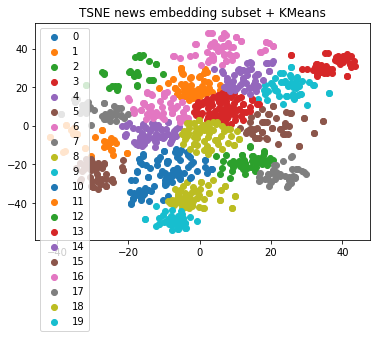

In [19]:
from sklearn.metrics import calinski_harabasz_score

kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=20, # we chose 20 because score is greater
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

calinski_harabasz_score = calinski_harabasz_score(tsne_news_embeddings_subset, kmeans_clusts_news_embeddings_subset)
print(f"calinski_harabasz_score is {calinski_harabasz_score}")

plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [20]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset == 5].Text.to_list()[:10]

['Россия выстоит💪🏼🇷🇺\nМнение жителей столицы Поморья о ситуации в Украине и западных санкциях — в очередном выпуске программы «Люди говорят» телеканала «Регион29» 👍🏼👇🏻\n#ZаРоссию\nВидео от Устьянский край | новости Устьянского района',
 'Всплеск спроса на драгметалл произошёл после начала спецоперации на Украине\nhttps://secretmag.ru/investment/lyudi-po-vsemu-miru-brosilis-skupat-zoloto-13-03-2022.htm?utm_source..\nhttps://secretmag.ru/investment/lyudi-po-vsemu-miru-brosilis-skupat-zoloto-13-03-2022.htm?utm_source=sfvk&amp;utm_medium=social',
 '[2/10] Жизнь какого села представлена в произведениях Гоголя?\nРусское\nБелорусское\nУкраинское\nПольское',
 '. - Меня это не обижает, но это опасно для духовной жизни тех людей, которые в малом отступают от истины".\n\nПатриарх сказал, что он никого не осуждает, а “своим скорбящим сердцем” максимально хочет понять этих людей.\n\n“Но одновременно сознаю, что если в малом неверен, то ведь и в большом может быть неверным", - добавил патриарх.\n\nП

In [21]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset == 7].Text.to_list()[:10]

['На антивоенную акцию у Гостиного двора в этот раз пришло не так много людей, но это не помешало силовикам задержать не менее 53 человек. В автозаки увели более десятка журналистов, есть сообщения о задержании случайных прохожих.\nЧитайте на зеркале «Бумаги»: https://ppr.today/hGS4YvW\nРоскомнадзор заблокировал сайт «Бумаги» из-за освещения ситуации в Украине, но мы продолжаем работу. Установите VPN: https://ppr.today/65Q689i',
 'В Москве на Манежной площади проходит акция против боевых действий на Украине. Митингующих задерживают',
 '«Ковчег» — проект для людей, которые уехали из России по политическим причинам. Чем он может помочь?\nhttps://ppr.today/9OeiIsh\nРоскомнадзор заблокировал сайт «Бумаги» из-за освещения ситуации в Украине, но мы продолжаем работу. Установите VPN: https://ppr.today/65Q689i',
 'Несколько десятков человек блокируют движение грузовиков с российскими и белорусскими регистрационными номерами, выезжающими из Польши.\n\nhttps://www.rubaltic.ru/news/13032022-ukrai

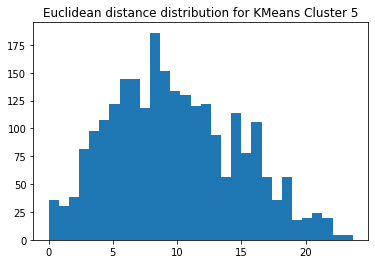

In [22]:
estimated_dists = pairwise_distances(
    tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == 5]
).flatten()

plt.title("Euclidean distance distribution for KMeans Cluster 5")
plt.hist(estimated_dists[estimated_dists != 0], bins=30)
plt.show()

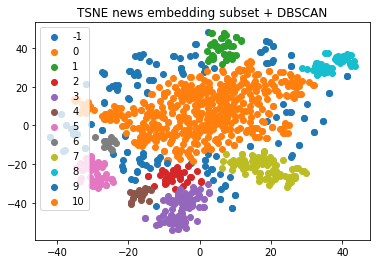

In [23]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=4,
    min_samples=10
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [24]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 4].Text.to_list()[:10]

['Украинские войска на попаснянском направлении использовали людей как живой щит, пытавшиеся бежать были расстреляны, сообщила народная милиция ЛНР',
 '❗Силовики ЛНР обнаружили места массового убийства мирных жителей в районе Попаснянской железной дороги, сообщает народная милиция республики.\nОтступающие украинские войска выгоняли людей из подвалов и использовали их в качестве живого щита — оказывавшие сопротивление или пытавшиеся бежать были расстреляны, заявили в ведомстве.\nВидео: Народная милиция ЛНР\nЭкстренное заявление Народной милиции ЛНР',
 'Наш земляк погиб во время спецоперации российских войск на Украине\nПодробнее ▶ https://glazovlife.ru/?p=41648',
 'Силы ЛНР в ходе наступления в районе Попасной обнаружили места массового убийства мирных жителей в районе железной дороги, сообщила народная милиция ЛНР. По ее данным, отступающие украинские войска выгоняли людей из подвалов и использовали их в качестве живого щита, тех, кто оказывал сопротивление или пытался бежать, расстрел

In [25]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 2].Text.to_list()[:10]

['❗️Силы ЛНР в ходе наступления на Попаснянском направлении обнаружили места массового убийства мирных жителей.\n\nКак сообщила сообщила народная милиция ЛНР, украинские войска использовали людей как живой щит. Пытавшиеся бежать были расстреляны.',
 '🔍Силы ЛНР нашли места массового убийства мирных жителей украинскими военными в районе Попаснянской железной дороги.\n\nПо данным Народной милиции республики, отступающие войска противника выгоняли людей из подвалов и использовали их в качестве живого щита. \n\nОказывавших сопротивление или пытавшихся бежать расстреляли.\n\nВ ведомстве заявили, что военные преступления не имеют срока давности и все виновные в геноциде населения Донбасса будут наказаны - RT.\n\n#кубань24 #украина #донбасс',
 '⚡️Украинские войска не выпускают из Рубежного, Северодонецка и Лисичанска мирных жителей, используют их как живой щит, заявляет народная милиция ЛНР.',
 'сообщение Кремля. Там отметили, что националистические батальоны Украины срывают операции по эвакуа

In [26]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 8].Text.to_list()[:10]

['Киев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий. https://kaktus.media/456168\r\nСоветник президента Украины: Россия уже адекватнее смотрит на ситуацию\r\nКиев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий.\r\nhttps://kaktus.media/456168',
 'Четвертый очный раунд переговоров между Россией и Украиной может пройти в начале следующей недели\nПодробнее здесь:\xa0https://bit.ly/37ewjHJ',
 'Член российской делегации на переговорах с Украиной Леонид Слуцкий — о прогрессе в диалоге с Киевом: Если сравнивать позиции обеих делегаций на переговорах в самом их начале и сегодня, то мы увидим существенный прогресс. \n\nПо словам депутата, этот прогресс может перерасти в самое ближайшее время в единую позицию обеих делегаций, в документы для подписания\n\n@truekpru',
 '⚡️Прогресс в переговорах между Россией и Украиной в ближайшее время может перерасти в единую позицию обеих делегаций, заявил Слуцкий.',
 '⚡️ Член российской делегаци

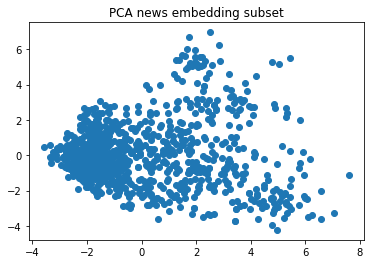

In [27]:
pca_news_embeddings_subset = PCA(random_state=42).fit_transform(news_embeddings_no_dupl[:1000])

plt.title("PCA news embedding subset")
plt.scatter(pca_news_embeddings_subset[:,0], pca_news_embeddings_subset[:,1])
plt.show()

# TODO: Try to twick `svd_solver` and apply different clustering approaches

## Example, where it does not work

In [28]:
dec_2022_mask = df_no_dupl["Date"].apply(lambda x: x.month).isin([12])
print(f"Number of unique News for December of 2022 = {dec_2022_mask.sum()}")

Number of unique News for December of 2022 = 70657


In [29]:
dec_2022_df = df_no_dupl[dec_2022_mask].reset_index(drop=True)
dec_2022_news_embeddings = news_embeddings_no_dupl[dec_2022_mask.values]

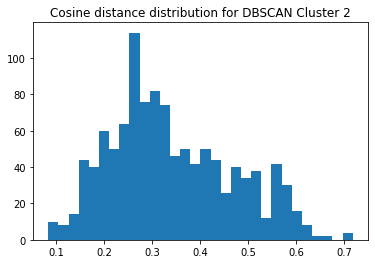

In [30]:
cosine_dists = pairwise_distances(
    news_embeddings_no_dupl[:1000][dbscan_clusts_news_embeddings_subset == 2],
    metric="cosine"
).flatten()

plt.title("Cosine distance distribution for DBSCAN Cluster 2")
plt.hist(cosine_dists[cosine_dists != 0], bins=30)
plt.show()

In [31]:
dbscan_clusts_dec_2022_news_embeddings = DBSCAN(
    eps=0.2,
    min_samples=10,
    metric="cosine",
).fit_predict(dec_2022_news_embeddings)

In [32]:
pd.Series(dbscan_clusts_dec_2022_news_embeddings).value_counts()

 0     57276
-1     13078
 2        52
 3        36
 6        30
 4        26
 1        21
 13       20
 14       17
 7        17
 15       14
 5        13
 10       11
 12       11
 17        9
 16        8
 9         6
 11        6
 8         6
dtype: int64

In [33]:
dec_2022_df[dbscan_clusts_dec_2022_news_embeddings==3].Text.to_list()[:10]

['Последние новости и сводки о ходе спецоперации на Украине от известного журналиста и блогера Юрия Подоляки: наступление на Донецком направлении, борьба за Марьинку, сражение за Артемовск, состояние украинской энергетической отрасли.\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022',
 'Последние новости и сводки о ходе спецоперации на Украине от известного журналиста и блогера Юрия Подоляки: наступление на Донецком направлении, борьба за Марьинку, сражение за Артемовск, состояние украинской энергетической отрасли.\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022\r\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022',
 'Последние новости и сводки о ходе спецоперации на Украине от известного журналиста и блогера Юрия Подоляки: продвижение на Сватовском и Артемовском направлении, передислокация ВСУ, атаки в районе Водяново, бои за Марьинку, судьба украинской п

In [34]:
dec_2022_df[dbscan_clusts_dec_2022_news_embeddings==15].Text.to_list()[:10]

['1 декабря. События дня.\n#смоленск #россия #украина #спецоперация #событиядня\r\n1 декабря. События дня\r\n«Единая Россия» приглашает смолян присоединиться к акции «Новогодняя почта» ...\r\nhttps://smolgazeta.ru/daylynews/106305-1-dekabrya-sobytiya-dnya.html',
 '2 декабря. События дня.\n#смоленск #россия #украина #событиядня #сво\r\n2 декабря. События дня\r\nДля погибших на Украине польских наёмников вынуждены открыть отдельное ...\r\nhttps://smolgazeta.ru/daylynews/106341-2-dekabrya-sobytiya-dnya.html',
 '8 декабря. События дня.\n#смоленск #россия #украина #спецоперация #сво #событиядня\r\n8 декабря. События дня\r\nАлексей Островский сделал контрольные звонки семьям мобилизованных ...\r\nhttps://smolgazeta.ru/daylynews/106497-8-dekabrya-sobytiya-dnya.html',
 '9 декабря. События дня.\n#смоленск #россия #украина #спецоперация #событиядня\r\n9 декабря. События дня\r\nСмоленские росгвардейцы провели урок мужества для кадетов. ...\r\nhttps://smolgazeta.ru/daylynews/106519-9-dekabrya-soby

## Conclusions 

**Use Cases**
- Contextual duplicates merging
- Text exploratary data analysis

**Main Problems**
- Requires hard hyper-parameter tunning  
- Optimal parameters for one subset may not be optimal for another one
- Lacks some good metrics 
- Hardly rely on the shape of dataspace

<a id='Topic_Modelling'></a>
# Topic Modelling

## [LDA Model](https://radimrehurek.com/gensim/models/ldamodel.html)

[Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

In natural language processing, Latent Dirichlet Allocation (LDA) is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. The LDA is an example of a topic model. In this, observations (e.g., words) are collected into documents, and each word's presence is attributable to one of the document's topics. Each document will contain a small number of topics. 

In [35]:
nltk.download("stopwords")
ru_stopwords = stopwords.words("russian")
ru_stopwords_puncts = set(ru_stopwords) | set(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
nltk.download('punkt')

docs = []
for d in tqdm(df_no_dupl.iloc[:1000]['Text_processed'].to_list()):
    docs.append(
        [el.lower() for el in tokenize.word_tokenize(d) if el.lower() not in ru_stopwords_puncts]
    )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 1000/1000 [00:00<00:00, 1190.40it/s]


In [37]:
# Create Dictionary
vocab = corpora.Dictionary(docs)
# doc2bow means Doc transformed to Bag of Words
corpus = [vocab.doc2bow(text) for text in docs]
# View
print(
    f"Text:\n{' '.join(docs[0])}\n\n"
    f"Text BOW:\n{corpus[0]}"
)

Text:
россияне посмотрите действительно свободных людей такое видели по-телевизору хотя пиздец это мелитополь которому оккупанты запретили протесты подбирая выражений скажу хуй клали запреты каких-то грязных захватчиков последняя прочитанная книга которых букварь смотрите видео чему-то научитесь рабы

Text BOW:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]


In [38]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab,
                                       num_topics=num_topics,
                                       passes=10,
                                       workers=2)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.014*"украине" + 0.007*"украины" + 0.004*"спецоперации" + 0.004*"россии" + '
  '0.004*"области" + 0.003*"заявил" + 0.003*"время" + 0.003*"видео" + '
  '0.003*"рф" + 0.003*"италии"'),
 (1,
  '0.017*"украине" + 0.007*"жителей" + 0.007*"спецоперации" + 0.006*"лнр" + '
  '0.005*"россии" + 0.005*"мирных" + 0.005*"украины" + 0.005*"места" + '
  '0.005*"убийства" + 0.005*"массового"'),
 (2,
  '0.014*"украине" + 0.012*"times" + 0.010*"new" + 0.009*"york" + 0.008*"рено" '
  '+ 0.008*"the" + 0.008*"``" + 0.007*"\'\'" + 0.007*"представитель" + '
  '0.007*"работал"'),
 (3,
  '0.013*"украине" + 0.005*"которые" + 0.005*"россии" + 0.004*"это" + '
  '0.004*"который" + 0.004*"украинские" + 0.004*"президент" + '
  '0.004*"поддержку" + 0.004*"``" + 0.004*"днр"'),
 (4,
  '0.017*"украине" + 0.015*"кадыров" + 0.008*"рамзан" + 0.008*"украины" + '
  '0.007*"глава" + 0.006*"видео" + 0.006*"спецоперации" + 0.006*"украину" + '
  '0.006*"прибыл" + 0.006*"операции"'),
 (5,
  '0.020*"украине" + 0.017*"сша"

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, vocab)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.037372 -0.198996       1        1  16.397443
8     -0.188917  0.101633       2        1  11.663044
1     -0.009738 -0.021871       3        1  11.339356
5      0.158257  0.113424       4        1  11.111029
6     -0.141113 -0.001007       5        1  10.985927
2      0.126149  0.068607       6        1   9.507844
9     -0.008045 -0.018403       7        1   9.113804
4      0.018103 -0.000629       8        1   6.999797
3      0.014126 -0.035642       9        1   6.837657
0     -0.006193 -0.007116      10        1   6.044100, topic_info=             Term       Freq       Total Category  logprob  loglift
2076         рено  97.000000   97.000000  Default  30.0000  30.0000
2041        times  71.000000   71.000000  Default  29.0000  29.0000
238       кадыров  63.000000   63.000000  Default  28.0000  28.0000
2381      слуцкий  61.000000   61.000000  Default  27.0000  27.0000
568   переговорах  68.000000   68.000000  Default  26.0000  26.0000
...           ...        ...         ...      ...      ...      ...
34            это   4.554910  100.305953  Topic10  -6.1782  -0.2859
1296   территории   4.416038   43.597361  Topic10  -6.2092   0.5163
131        против   4.474806  101.012474  Topic10  -6.1960  -0.3107
580       военной   4.451034   79.175714  Topic10  -6.2013  -0.0724
145       украина   4.366446   43.986645  Topic10  -6.2205   0.4962

[688 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
305       1  0.261929          ''
305       2  0.043655          ''
305       3  0.087310          ''
305       4  0.074837          ''
305       5  0.037418          ''
...     ...       ...         ...
4186      5  0.036637  яворовский
4186     10  0.036637  яворовский
7119      7  0.659169  яворовском
7119     10  0.219723  яворовском
8705      9  0.908771   ярмоленко

[1557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 2, 6, 7, 3, 10, 5, 4, 1])

## [BERTopic](https://github.com/MaartenGr/BERTopic)

BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

In [40]:
from bertopic import BERTopic
# TODO: Try different models and hyperparameters. Link https://github.com/MaartenGr/BERTopic 
topic_model = BERTopic(
    embedding_model="DeepPavlov/rubert-base-cased", 
    n_gram_range=(1, 1),
    min_topic_size=8,
    language='russian',
    nr_topics=30,
    verbose=True
    )

In [41]:
topics, probs = topic_model.fit_transform(df_no_dupl.iloc[:1000]['Text_processed'].to_list())

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-03-01 18:28:55,146 - BERTopic - Transformed documents to Embeddings
2023-03-01 18:29:16,523 - BERTopic - Reduced dimensionality
2023-03-01 18:29:16,606 - BERTopic - Clustered reduced embeddings
2023-03-01 18:29:21,619 - BERTopic - Reduced number of topics from 27 to 27


In [42]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,235,-1_на_что_не_украине
1,0,42,0_рф_объектов_иностранных_минобороны
2,1,45,1_рено_журналиста_гибели_times
3,2,25,2_лнр_массового_жителей_народной
4,3,37,3_кадыров_рамзан_чечни_прибыл
5,4,87,4_рф_иностранных_наемников_лнр
6,5,17,5_акции_против_площади_на
7,6,12,6_автопробег_поддержку_российских_организовали
8,7,25,7_кадыров_рамзан_приехал_чечни
9,8,18,8_сергей_бороться_участвующих_россияне


In [43]:
topic_model.get_topic(6)

[('автопробег', 0.10422391132378057),
 ('поддержку', 0.08909918120764479),
 ('российских', 0.0665684569942295),
 ('организовали', 0.06477838148513516),
 ('курская', 0.0615747464813971),
 ('улицам', 0.05398198457094597),
 ('акцию', 0.05398198457094597),
 ('москвичи', 0.05282121174790147),
 ('вооружившись', 0.05282121174790147),
 ('эстафета', 0.05282121174790147)]

In [44]:
topic_model.visualize_topics()

## Conclusions 

**Use Cases**
- Finding topics in big corpuses 
- Finding keywords for better topic configuration 

**Main Problems**
- Requires hard hyper-parameter tunning  
- Old prototypes work much worse comparing to new ones (Neural Nets + Clustering + TfIdf)
- May require decompostition on steps and each step twicking 

In [46]:
# TODO in which day we have more news, what about peaks on Data chart? 
# what events happened then, check if it is connected by getting top keywords 
# (maybe getting topic by this cluster) (parse information from somewhere)

### Some Statistics 

In [47]:
df.head()

,Title,Text,Saved at,Date,Time,lang,Text_processed
0,Опять оккупанты что-то попутали. Рассказывать ...,"Вот, россияне, посмотрите на действительно сво...",2022-03-13 12:21:10.126565500+00:00,2022-03-13,09:38:01,ru,"Вот, россияне, посмотрите на действительно сво..."
1,NaN,Русский солдат – фашистский оккупант!\n\nВот к...,2022-03-13 12:21:10.529583400+00:00,2022-03-13,12:20:08,ru,Русский солдат фашистский оккупант! Вот как Хе...
2,NaN,Обязательно посмотрите это видео!\n\nПутин хоч...,2022-03-13 12:21:12.613800100+00:00,2022-03-13,10:03:27,ru,Обязательно посмотрите это видео! Путин хочет ...
3,NaN,"Если я правильно все понимаю, то по версии рос...",2022-03-13 12:21:13.948660700+00:00,2022-03-13,11:49:51,ru,"Если я правильно все понимаю, то по версии рос..."
4,NaN,Опять оккупанты что-то попутали. Рассказывать ...,2022-03-13 12:21:14.146675+00:00,2022-03-13,09:34:03,ru,Опять оккупанты что-то попутали. Рассказывать ...


In [49]:
df['Date'].value_counts()

2022-10-10    6925
2022-03-29    6751
2022-03-14    6683
2022-03-16    6624
2022-03-17    6344
              ... 
2022-09-04    1557
2022-08-14    1448
2023-01-01    1269
2022-03-12      19
2022-03-11       1
Name: Date, Length: 326, dtype: int64

In [62]:
dates = df['Date'].sort_values().unique()
df2 = pd.DataFrame(dates, columns=['Date'])
df2

,Date
0,2022-03-11
1,2022-03-12
2,2022-03-13
3,2022-03-14
4,2022-03-15
...,...
321,2023-01-26
322,2023-01-27
323,2023-01-28
324,2023-01-29


In [68]:
date_counts = df['Date'].value_counts().sort_values()
date_counts.head()

2022-03-11       1
2022-03-12      19
2023-01-01    1269
2022-08-14    1448
2022-09-04    1557
Name: Date, dtype: int64

(array([19052., 19083., 19113., 19144., 19174., 19205., 19236., 19266.,
        19297., 19327., 19358., 19389.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

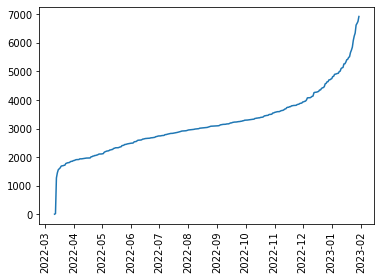

In [69]:
plt.plot(dates, date_counts)
plt.xticks(rotation='vertical')

here we can see that number of news increases significantly

In [70]:
def process_time(value):
  hours, minutes, seconds = value.split(":")
  return hours

df['at_hour'] = df['Time'].apply(process_time)
df['at_hour'].head()

0    09
1    12
2    10
3    11
4    09
Name: at_hour, dtype: object

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

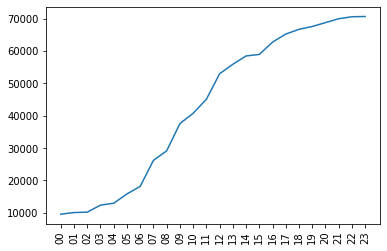

In [72]:
plt.plot(df['at_hour'].sort_values().unique(), df['at_hour'].value_counts().sort_values())
plt.xticks(rotation='vertical')

It says us that most number of news were posted in the evening when people are back home from work.

### Advanced Task

Try to implement some Class, which can:

- [x]  Automatically find topics
- [x]  Create descriptions for them: Keywords or/and Keyword N-Grams or/and other rules
- [ ]  Detect them and track them by Time

In [79]:
class TopicTracker:
  def __init__(self, corpus, vocab, n_topics=10, n_keywords=10):
    self.corpus=corpus
    self.vocab = vocab
    self.n_topics=n_topics
    self.n_keywords=n_keywords
    self.topics = {}
    
  def fit(self):
    self.lda_model = gensim.models.LdaMulticore(corpus=self.corpus,
                                       id2word=self.vocab,
                                       num_topics=self.n_topics,
                                       passes=10,
                                       iterations=200,
                                       workers=2)
    topic_term_matrix = self.lda_model.get_topics()

    for i in range(self.n_topics):
      topic_terms = self.lda_model.get_topic_terms(i, topn=self.n_keywords)
      keywords = [self.lda_model.id2word[term[0]] for term in topic_terms]
      self.topics[i] = {'keywords': keywords}
    
    pprint(self.lda_model.print_topics())

  def get_description(self, topic_id):
    keywords = self.topics[topic_id]['keywords']
    return ' '.join(keywords)

  def get_timeline(self, topic_id):
    pass

  def belongs_to_topic(self, text):
    text_bow = self.lda_model.id2word.doc2bow(text.split(' '))
    topic_distribution = self.lda_model.get_document_topics(text_bow)

    top_topic = max(topic_distribution, key=lambda x: x[1])[0]

    print(self.get_description(0))
    print(top_topic)
    if any(keyword in text for keyword in self.topics[top_topic]['keywords']):
        print(f"The text '{text}' belongs to topic {top_topic}")
    else:
        print(f"The text '{text}' does not match any of the topic keywords")


In [80]:
topic_tracker = TopicTracker(corpus, vocab)
topic_tracker.fit()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

[(0,
  '0.013*"украины" + 0.009*"украине" + 0.008*"россии" + 0.007*"иностранных" + '
  '0.007*"рф" + 0.006*"против" + 0.005*"глава" + 0.005*"заявил" + '
  '0.005*"наемников" + 0.005*"минобороны"'),
 (1,
  '0.018*"рф" + 0.016*"украины" + 0.014*"россии" + 0.011*"украине" + '
  '0.010*"спецоперации" + 0.009*"вс" + 0.008*"иностранных" + 0.008*"объектов" '
  '+ 0.006*"военной" + 0.006*"сил"'),
 (2,
  '0.008*"украине" + 0.006*"украины" + 0.005*"которые" + 0.005*"россии" + '
  '0.004*"области" + 0.004*"спецоперации" + 0.004*"из-за" + 0.003*"россия" + '
  '0.003*"ситуации" + 0.003*"рф"'),
 (3,
  '0.018*"украине" + 0.014*"рено" + 0.011*"times" + 0.009*"new" + 0.009*"york" '
  '+ 0.009*"переговорах" + 0.009*"журналиста" + 0.009*"заявил" + '
  '0.009*"слуцкий" + 0.008*"гибели"'),
 (4,
  '0.015*"лнр" + 0.014*"мирных" + 0.013*"жителей" + 0.011*"массового" + '
  '0.010*"убийства" + 0.008*"украине" + 0.007*"народной" + 0.007*"места" + '
  '0.007*"районе" + 0.007*"\'\'"'),
 (5,
  '0.017*"украине" + 0.

In [74]:
topic_tracker.get_description(0)

'переговорах слуцкий прогресс украиной перерасти заявил делегаций леонид делегации позицию'

In [81]:
text = 'случилося что-то в Украине с кадыров'
topic_tracker.belongs_to_topic(text)

украины украине россии иностранных рф против глава заявил наемников минобороны
6
The text 'случилося что-то в Украине с кадыров' belongs to topic 6
